In [1]:
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess
import sys

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
from scipy.stats import fisher_exact
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
outdir = os.path.join(ciepy.root, 'output',
                      'ase_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'ase_analysis')
cpy.makedir(private_outdir)

In [48]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
meta = pd.read_table(fn, index_col=0)

tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
qvalues.columns = ['{}_gene'.format(x) for x in qvalues.columns]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)

genes = pbt.BedTool(cpy.gencode_gene_bed)

In [4]:
def make_snv_info():
    from Bio.Seq import Seq 
    fn = ('/raid3/projects/CARDIPS/pipeline/RNAseq/'
          'exonic_snps/heterozygous_exonic_snv_information.tsv')
    info = pd.read_table(fn, index_col=0)
    info['ref_allele_stranded'] = ''
    info['alt_allele_stranded'] = ''
    info.ix[info.strand == '+', 'ref_allele_stranded'] = info.ref_allele + info.strand
    info.ix[info.strand == '+', 'alt_allele_stranded'] = info.alt_allele + info.strand
    
    info.ix[info.strand == '-', 'ref_allele_stranded'] = (info.ref_allele.apply(
            lambda x: str(Seq(x).reverse_complement())) + info.strand)
    info.ix[info.strand == '-', 'alt_allele_stranded'] = (info.alt_allele.apply(
            lambda x: str(Seq(x).reverse_complement())) + info.strand)
    return info

In [5]:
info = make_snv_info()

In [10]:
locus_fns = glob.glob(os.path.join(ciepy.root, 'output', 'input_data', 'mbased_locus',
                                   '*_locus.tsv'))
snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

This is Table S8 from the 2015 GTEx paper.

                Total sites ≥30 reads | Sites 30 reads ASE p < 0.005 | Sites 30 reads ASE p < 0.005 (%)
    Minimum              221          |                8             |                 1.59%
    Median             6383.5         |              389.5           |                 5.99%
    Maximum             16422         |               1349           |                 15.0%

In [15]:
locus_res = {}
for fn in locus_fns:
    locus_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

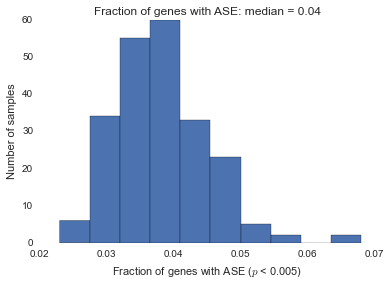

In [45]:
frac = []
for k in locus_res.keys():
    frac.append(sum(locus_res[k]['p_val_ase'] < 0.005) / float(locus_res[k].shape[0]))

plt.hist(frac)
plt.title('Fraction of genes with ASE: median = {:.2f}'.format(np.median(frac)))
plt.ylabel('Number of samples')
plt.xlabel('Fraction of genes with ASE ($p$ < 0.005)');

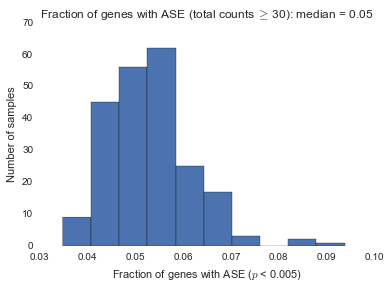

In [47]:
frac = []
for k in locus_res.keys():
    d = dict(zip(count_res[k]['feature'], count_res[k]['totalFeatureCount']))
    t = locus_res[k]
    t['totalFeatureCount'] = [d[i] for i in t.index]
    t = t[t.totalFeatureCount >= 30]
    frac.append(sum(t['p_val_ase'] < 0.005) / float(t.shape[0]))

plt.hist(frac)
plt.title('Fraction of genes with ASE (total counts $\geq$ 30): median = {:.2f}'.format(np.median(frac)))
plt.ylabel('Number of samples')
plt.xlabel('Fraction of genes with ASE ($p$ < 0.005)');

In [104]:
p = pd.Panel(locus_res)

In [105]:
df = p.ix[:, :, 'p_val_ase']
df = df[meta[meta.in_eqtl].index]
df = df.ix[set(df.index) & set(qvalues.index)]

s = set(df.index) & set(qvalues[qvalues.sig_gene].index)
ns = set(df.index) & set(qvalues[qvalues.sig_gene == False].index)

t = df.ix[s]
s_s = (t[t.isnull() == False] < 0.005).sum().sum()
s_ns = (t[t.isnull() == False] >= 0.005).sum().sum()
t = df.ix[ns]
ns_s = (t[t.isnull() == False] < 0.005).sum().sum()
ns_ns = (t[t.isnull() == False] >= 0.005).sum().sum()
odds, pval = fisher_exact([[s_s, s_ns], [ns_s, ns_ns]])
print('eQTL genes enriched for ASE with p = {}'.format(pval))

eQTL genes enriched for ASE with p = 0.0
